## Unsupervised final assignment

* Data: primates-morphology.csv
* Author: Peter Riesebos

### Table of contents:
- Data inspection and cleanup
- PCA
- Model Creation
    - Kmeans
    - DBScan
- Conclusion

Importing libraries, modules and the data

In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn import metrics

In [191]:
data = pd.read_csv("./Data/primates-morphology.csv")
df = data.copy()
df.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,25,26,27,28,29,Abbreviation,Genus,Species,Sex,Age
0,37773,133.426742,-101.627603,21.125902,-11.518251,4.621089,-1.519551,0.583410,-7.182875,1.410030,...,-0.301822,-0.433051,0.037651,-0.279618,-0.421040,Ph,Presbytis,hosei,U,A
1,37772,145.344740,-108.229812,21.121390,-14.982879,2.299335,-2.354040,0.431199,-5.266930,-1.424469,...,0.215340,-0.299550,0.709472,0.876382,-0.150133,Ph,Presbytis,hosei,F,A
2,22276,137.773342,-107.162743,18.232497,-17.116294,3.016809,-5.295234,1.716895,-1.668914,-1.917478,...,-0.481468,-0.243025,-0.537644,-0.140292,0.082158,Pr,Presbytis,rubicunda,U,A
3,37776,141.523739,-107.436626,17.448083,-16.861469,3.382894,-1.071286,1.768891,-2.735232,-1.136700,...,0.586941,-0.043639,-0.518699,-1.051100,0.542354,Pr,Presbytis,rubicunda,M,A
4,37777,142.357906,-97.195294,10.511391,-6.520641,3.555506,1.652390,-0.655919,-5.373075,-1.466841,...,0.653851,0.718319,0.798722,-0.396749,0.844772,Pr,Presbytis,rubicunda,F,A


### Data inspection and cleanup

Inspecting the data for missing values, distribution, linearity,  skewness, and it's correlations

In [192]:
df.info() # general dataframe info
na_count = df.isna().sum().sum() # there doesn't seem to be any missing data
df.drop('Unnamed: 0', axis=1, inplace=True) # dropping the unneeded, presumably index column

print(f'Empty value count: {na_count}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165 entries, 0 to 164
Data columns (total 36 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    165 non-null    int64  
 1   0             165 non-null    float64
 2   1             165 non-null    float64
 3   2             165 non-null    float64
 4   3             165 non-null    float64
 5   4             165 non-null    float64
 6   5             165 non-null    float64
 7   6             165 non-null    float64
 8   7             165 non-null    float64
 9   8             165 non-null    float64
 10  9             165 non-null    float64
 11  10            165 non-null    float64
 12  11            165 non-null    float64
 13  12            165 non-null    float64
 14  13            165 non-null    float64
 15  14            165 non-null    float64
 16  15            165 non-null    float64
 17  16            165 non-null    float64
 18  17            165 non-null    

Here we inspect the data for it's data types and missing values as well as dropping the unneeded 'Unnamed 0' column

In [193]:
features = list(df.columns[:30]) # selecting the value columns

df_values = df[features]
df_labels = df['Species']

Here we create two subsets of the data for which we are going to do unsupervised machine learning on. We seperate the data in the values and labels.

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
count,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,...,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000
mean,5.537129,1.196007,-0.125596,0.774423,-0.161111,-0.182550,-0.077955,0.180683,0.132617,-0.030271,...,0.057334,-0.014223,0.013269,-0.002892,0.005006,0.003208,-0.001137,-0.002748,-0.012738,-0.013131
std,99.061556,69.971050,56.627559,18.591984,11.336600,8.710069,5.463093,5.214248,4.520787,3.389125,...,1.254471,1.161247,0.971599,0.932425,0.865874,0.750532,0.720479,0.484438,0.461879,0.374258
min,-201.591249,-111.659165,-114.986835,-54.636918,-19.375303,-24.431319,-54.611282,-20.855026,-18.487708,-13.764311,...,-3.793245,-2.894577,-3.849517,-1.838070,-2.274559,-2.037714,-2.934118,-1.245955,-2.115305,-1.128128
25%,-58.767559,-44.542377,-45.981261,-12.328664,-7.348686,-5.823589,-1.389680,-2.572926,-2.279476,-1.834020,...,-0.697783,-0.739499,-0.482541,-0.585089,-0.587203,-0.413921,-0.411248,-0.300449,-0.320591,-0.248282
50%,-4.994670,18.343281,-2.090244,4.082730,-2.158090,-1.071286,-0.124301,-0.379776,-0.057433,-0.158941,...,0.086293,-0.103932,0.123128,-0.072030,-0.018886,-0.023107,-0.022457,0.001251,-0.018000,-0.010527
75%,89.480991,42.633134,32.805157,16.969797,3.716401,5.078963,1.575336,3.017432,3.199454,1.722897,...,0.784991,0.633467,0.526249,0.512882,0.621830,0.474782,0.418680,0.274560,0.277566,0.268744
max,192.170450,433.444316,142.161119,33.486208,68.005131,21.570367,18.598186,20.232449,18.859660,11.154277,...,3.300278,3.376167,3.423704,4.006407,3.131717,2.052453,2.727110,1.319978,1.653007,0.844772


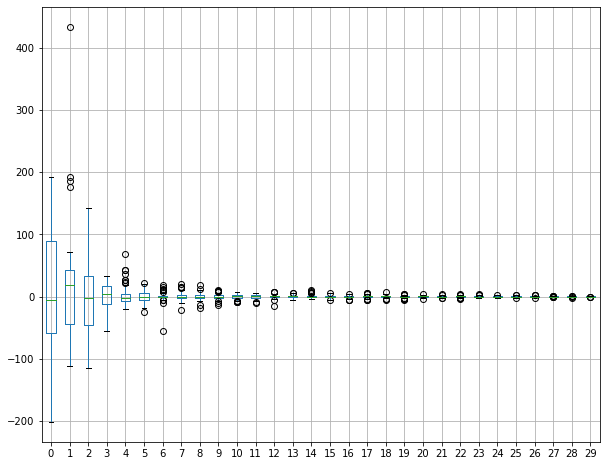

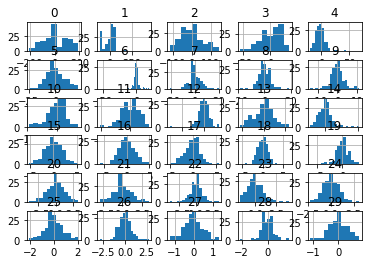

In [194]:
plt.figure(figsize=(10,8))
df_values.boxplot()
df_values.hist(bins='auto')
df.describe()

After doing some futher data inspection we find that the first six columns seem to differ the most in their regards to their value ranges. most columns however seem to be distrubuted normally. Also, some outliers can be observed. Particularly for the second column (column 1).

4     2.358456
1     1.272854
14    1.267799
23    0.782396
2     0.408304
7     0.348291
5     0.262781
26    0.211428
24    0.192550
21    0.144393
dtype: float64


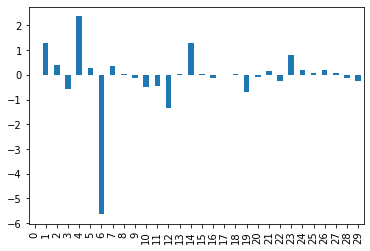

In [195]:
skewness = df_values.skew()
skewness_sorted = skewness.sort_values(ascending=False)
skewness.plot(kind = 'bar')
print(skewness_sorted[:10])

The data seems to be especially skewed for column 4 and 6. However, I won't be doing any normalization because the data has already been preprocessed according to Tsjerk.

<AxesSubplot:>

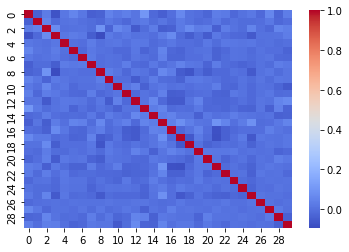

In [196]:
correlation = df_values.corr()
sn.heatmap(correlation, annot=False, cmap="coolwarm")

There do not appear to be any notheworthy correlations in the data. Drawing any futher conclusions from the data doesn't seem to be useful since the data is in coordinates space.

In [197]:
value_count = pd.DataFrame(df['Species'].value_counts().reset_index())
value_count

,index,Species
0,cristata,18
1,lar,18
2,polykomos,10
3,mitis,10
4,badius,10
5,troglodytes,9
6,larvatus,9
7,anubis,9
8,torquatus,9
9,fascicularis,8


Lastly we inspect how many values each species has in the dataset. Which shows us that a lot of species have a little amount of values. This is not preferable. Hence we set the cut off point for the value count a species must have to 7 which is a little bit above the middle.

In [198]:
selection = value_count[value_count['Species'] >= 7]['index'].tolist()
selection

['cristata',
 'lar',
 'polykomos',
 'mitis',
 'badius',
 'troglodytes',
 'larvatus',
 'anubis',
 'torquatus',
 'fascicularis',
 'rubicunda']

This leaves us with 11 species of interest

### PCA

With the use of PCA I will visualize the distribution of the species in 2d and 3d space

In [199]:
# only get the data where the species are the ones we filtered earlier
updated_df = df[df['Species'].isin(selection)]

# split the data in values and labels again
X = updated_df[df_values.columns]
y = updated_df['Species']

In [200]:
pca = PCA(n_components=2)
components = pca.fit_transform(X)

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

fig = px.scatter(components, x=0, y=1, color=y)

for i, feature in enumerate(X.columns):
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=loadings[i, 0],
        y1=loadings[i, 1]
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
    )
fig.show()

In [201]:
pca = PCA(n_components=3)
components = pca.fit_transform(X)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=y,
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'},
)
fig.show()

The clusters with the chosen species seems verily seperated. There is however still some overlap and split up species.

### Model creation

#### KMeans

I choose to use k-means because it's a very popular clustering algorithm that is known to run very fast and it excels in seperating the space in different sub-clusters.

In [202]:
km = KMeans(11) # number of clusters set to 11 since we hope to get 11 different species

found_clusters_km = km.fit_predict(X)

cluster_data_km = X.copy()
cluster_data_km['Data'] = found_clusters_km

# using the last pca's result we will plot the found clusters using kmeans


fig = px.scatter(components, x=0, y=1, color=cluster_data_km['Data'], title= 'Found clusters with KMeans')
fig.show()

fig = px.scatter(components, x=0, y=1, color=y, title= 'Real clusters')
fig.show()

It can be seen that a lot of data is still overlapping too much to find clusters that make sense. This is mostly due to outliers and species that have their cluster spread out widely. It is handy that you can indicate how many clusters are expected to be found which helps a bit in getting the right amount of clusters. This however, is no guarentee for finding the exact amount of clusters that you expected.

#### DBScan

I choose to use DBscan since it does a great job of seeking areas in the data that have a high density of observations versus areas of the data that are not very dense with observations.

In [203]:
dbscan = DBSCAN(eps=50, min_samples=3)
found_clusters_db = dbscan.fit_predict(X)

cluster_data_db = X.copy()
cluster_data_db['Data'] = found_clusters_db

fig = px.scatter(components, x=0, y=1, color=cluster_data_db['Data'], title= 'Found clusters with DBSCAN')
fig.show()

fig = px.scatter(components, x=0, y=1, color=y, title= 'Real clusters')
fig.show()

Using DBScan even less clusters are found since there is no parameter for number of clusters to look for. As well as the method it self having difficulty with finding multiple clusters in overlapping data.

In [204]:
# Evaluate the accuracy of our cluster finding methods
print('KMeans:',metrics.adjusted_rand_score(cluster_data_km['Data'], updated_df['Species']))
print('DBScan:',metrics.adjusted_rand_score(cluster_data_db['Data'], updated_df['Species']))

KMeans: 0.5462570697466903
DBScan: 0.3444610142592457


### Conclusion

The clustering functions aren't finding a lot of correct clusters. This is mostly due to clusters having overlap which makes a lot of clustering methods have a hard time with identifying the correct clusters. To improve this, the data could undergo even more filtering so no overlapping or split up clusters are present or different clustering finding methods could be used with finetuned parameters to get the best results. In my case DBScan combined with a lack of cleaning the data would be the bad approach, whereas KMeans would be the good approach in this case. Finding more than 50% of the correct clusters when there is so much overlap.